In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

# car evaluation 데이터 CSV 파일 경로 설정
file_path = "/content/drive/MyDrive/car_evaluation.csv"

# 컬럼명 리스트를 만들고 CSV 파일을 읽어올 때 컬럼명 부여
column_names = ["price", "maint", "doors", "persons", "lug_capacity", "safety", "output"]
df = pd.read_csv(file_path, names=column_names, header=None)

# 데이터프레임 확인
display(df.head())
print("컬럼 목록:", df.columns)

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


컬럼 목록: Index(['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety',
       'output'],
      dtype='object')


In [12]:
# 결측치 확인
print(df.isnull().sum(),"\n")

price           0
maint           0
doors           0
persons         0
lug_capacity    0
safety          0
output          0
dtype: int64 



In [14]:
# 레이블의 데이터 비율을 확인(imbalanced data인지 확인)
print(df['output'].value_counts(),"\n")

output
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64 



# Y를 원-핫 인코딩

In [15]:
y = df['output']   # 레이블(Label) 데이터
Y = pd.get_dummies(y).values
Y

array([[False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       ...,
       [False, False,  True, False],
       [False,  True, False, False],
       [False, False, False,  True]])

# X를 숫자로 변환 및 Numpy 변환

In [40]:
'''
df_encoded = pd.get_dummies(df, columns=['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety'])
'''
# 컬럼 값들이 문자열인 경우, 숫자로 바꿔줘야 함. 원-핫 인코딩 또는 Label Encoder
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()  # 원본 데이터 유지
for col in ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety']:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

X = df_encoded.drop(columns=['output']).values.astype(np.float32)
X

array([[3., 3., 0., 0., 2., 1.],
       [3., 3., 0., 0., 2., 2.],
       [3., 3., 0., 0., 2., 0.],
       ...,
       [1., 1., 3., 2., 0., 1.],
       [1., 1., 3., 2., 0., 2.],
       [1., 1., 3., 2., 0., 0.]], dtype=float32)

# Data split & shape 확인

In [41]:
# x/y데이터. train/test 데이터 분리 (학습 80%, 테스트 20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# shape 출력(인스턴스의 개수, 특성의 개수)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1382, 6), (1382, 4), (346, 6), (346, 4))

# Sequential 모델 생성

In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD,Adam


model = Sequential()

model.add(Dense(6,input_shape=(6,),activation='relu')) # input_shape 숫자를 컬럼의 개수와 맞추지 않으면 오류 발생
model.add(Dense(20,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['mse'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                     │ (None, 6)                   │              42 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 20)                  │             140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 4)                   │              84 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 686 (2.68 KB)

 Trainable params: 686 (2.68 KB)

 Non-trainable params: 0 (0.00 B)

# 모델에 fit

In [55]:
N_EPOCHS = 10

# validation data에 Y_test를 넣어서 train하면 안됨
model_history=model.fit(x=X_train, y=Y_train, epochs=N_EPOCHS, batch_size=32,validation_split=0.1)
Y_pred = model.predict(X_test)

# one-hot encoding 데이터를 정수 라벨로 변환
Y_test_class = np.argmax(Y_test, axis=1)
Y_pred_class = np.argmax(Y_pred, axis=1)

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0582 - mse: 0.0071 - val_loss: 0.1440 - val_mse: 0.0220
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0565 - mse: 0.0065 - val_loss: 0.1336 - val_mse: 0.0169
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0473 - mse: 0.0052 - val_loss: 0.1148 - val_mse: 0.0147
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0634 - mse: 0.0077 - val_loss: 0.1510 - val_mse: 0.0220
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0560 - mse: 0.0058 - val_loss: 0.1106 - val_mse: 0.0141
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0585 - mse: 0.0068 - val_loss: 0.1388 - val_mse: 0.0207
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0541 - mse: 0.0062 - val_loss: 0.1414 - val_mse: 0.0207
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0549 - mse: 0.0061 - val_loss: 0.1395 - val_mse: 0.0208
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0511 - mse: 

# loss 체크

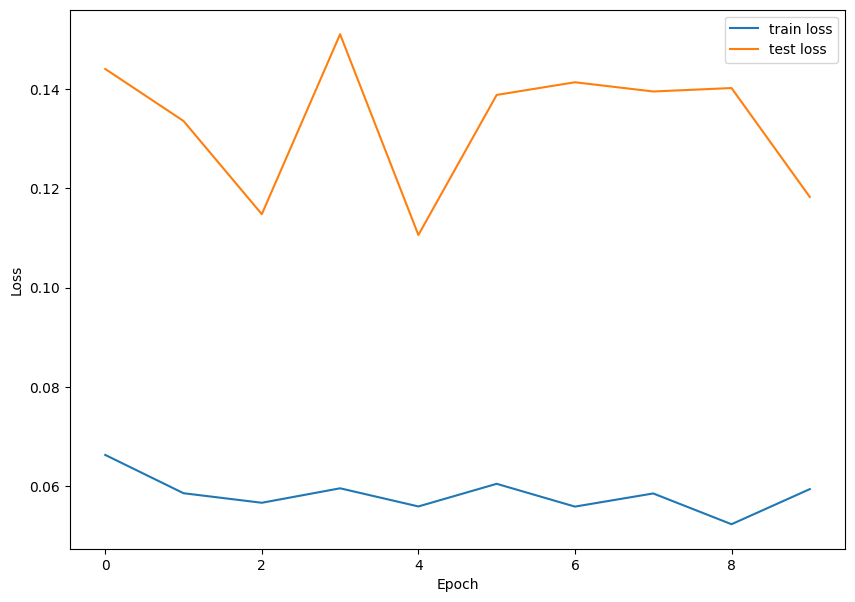

In [57]:
# loss 체크
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(range(N_EPOCHS), model_history.history['loss'], label='train loss')
plt.plot(range(N_EPOCHS), model_history.history['val_loss'], label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 정확도 평가

In [56]:
model.evaluate(X_test, Y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1427 - mse: 0.0220 


[0.11199533194303513, 0.01660941168665886]